In [1]:
import pandas as pd

from extract_transform import get_word_counts, sort_word_counts
from visualize import plot_wordcloud, plot_word_counts

In [3]:
osm_data = pd.read_json('data/preprocessed_osm_data.json.gz')
wikidata = pd.read_json('data/preprocessed_wikidata.json')

In [4]:
wikidata.head(5)

,qid,preprocessed_names,preprocessed_description
0,Q37158,starbucks starbucks corporation starbucks coff...,american multinational coffee company
1,Q154950,royal dutch shell rds shell royal dutch shell plc,anglo dutch oil company
2,Q1208279,petro canada,company
3,Q867662,esso exxcon,oil gas company
4,Q175106,tim hortons tim hortons inc,multinational quick service restaurant chain


In [5]:
# TODO - discuss chain restaurants / franchises with descriptions that do not contain the words
# 'chain' or 'restaurant', how 'corporation' in names may not be good indicator

In [6]:
names = wikidata['preprocessed_names']
descriptions = wikidata['preprocessed_description']

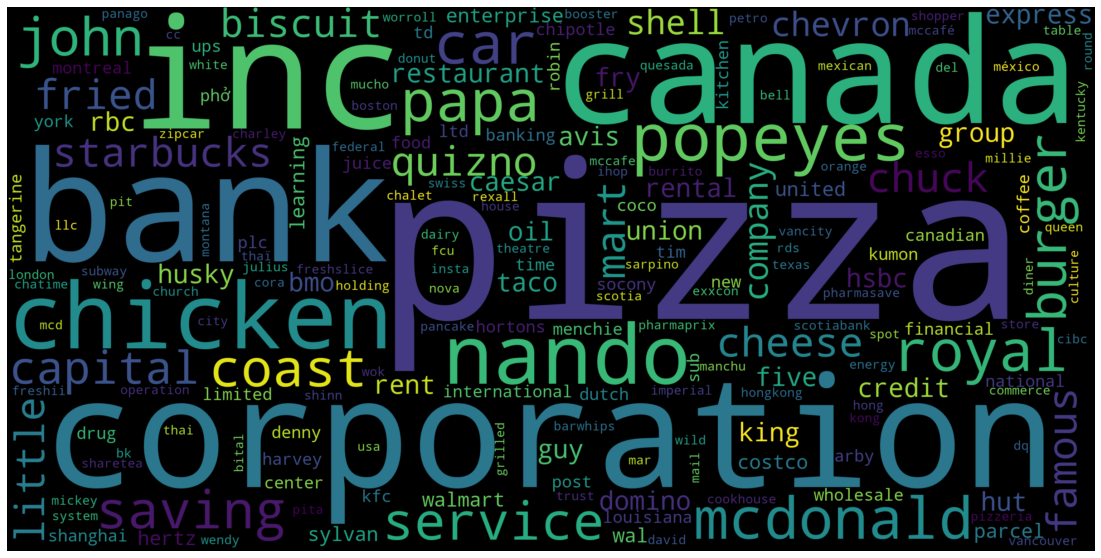

In [7]:
name_text = ' '.join(names)
plot_wordcloud(name_text)

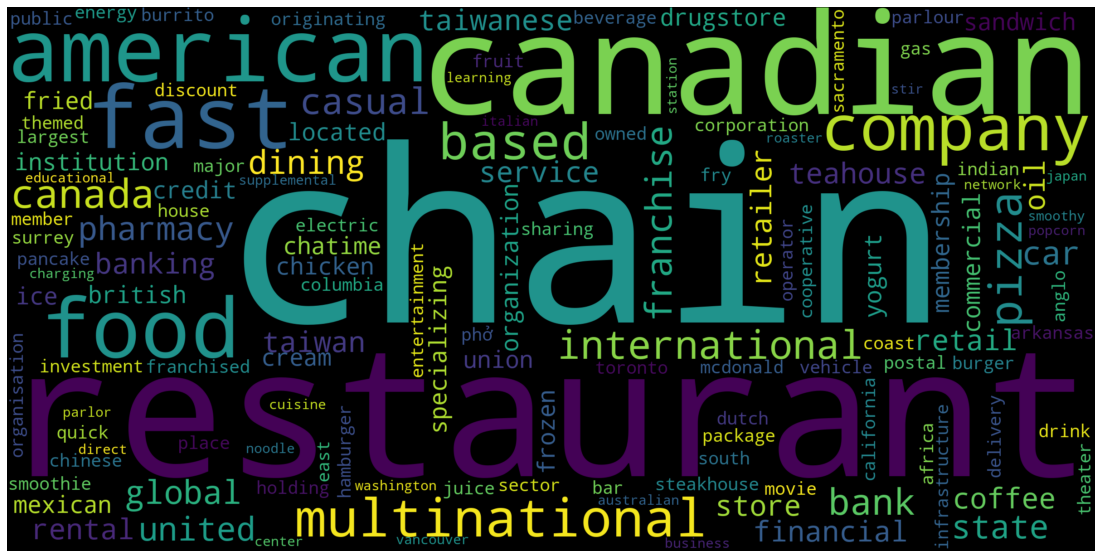

In [8]:
description_text = ' '.join(descriptions)
plot_wordcloud(description_text)

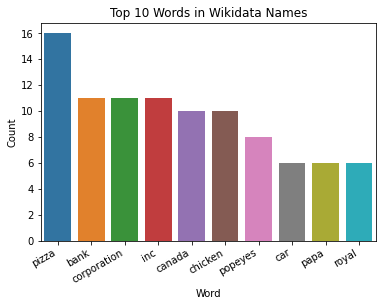

In [9]:
name_word_counts = get_word_counts(names)
name_word_counts = sort_word_counts(name_word_counts)
plot_word_counts(name_word_counts, 'Names')

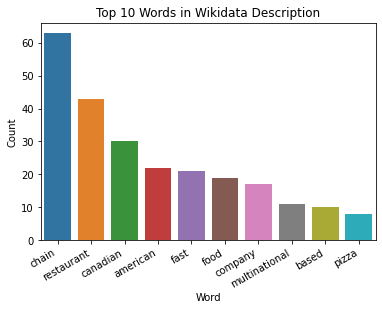

In [10]:
description_word_counts = get_word_counts(descriptions)
description_word_counts = sort_word_counts(description_word_counts)
plot_word_counts(description_word_counts, 'Description')